In [1]:
!pip install --quiet transformers

In [2]:
pip install Sentencepiece

In [7]:
import numpy

In [8]:
import pickle # reading in our data

import torch # pytorch
from torch.utils.data import DataLoader # this helps us iterate over our data efficiently
from tqdm import tqdm

In [9]:
import transformers

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
cd /content/drive/MyDrive/datasets


/content/drive/MyDrive/datasets


### Load training data

In [12]:
with open('/content/drive/MyDrive/datasets/covidqa/covid_train_contexts.pkl', 'rb') as f1:
  train_contexts = pickle.load(f1)

In [13]:
with open('/content/drive/MyDrive/datasets/covidqa/covid_train_questions.pkl', 'rb') as f2:
  train_questions = pickle.load(f2)

In [14]:
with open('/content/drive/MyDrive/datasets/covidqa/covid_train_answers.pkl', 'rb') as f3:
  train_answers = pickle.load(f3)

### Load validation data

In [15]:
with open('/content/drive/MyDrive/datasets/covidqa/covid_val_contexts.pkl', 'rb') as f1:
  val_contexts = pickle.load(f1)

In [16]:
with open('/content/drive/MyDrive/datasets/covidqa/covid_val_questions.pkl', 'rb') as f2:
  val_questions = pickle.load(f2)

In [17]:
with open('/content/drive/MyDrive/datasets/covidqa/covid_val_answers.pkl', 'rb') as f3:
  val_answers = pickle.load(f3)

In [18]:
def add_end_index(answers, contexts):

  # loop over each context-answer pair
  for answer, context in zip(answers, contexts):

    # the actual answer
    expected_answer = answer['text']

    # start index of the answer
    start_index = answer['answer_start']

    # end index
    end_index = start_index + len(expected_answer)

    # take into account if answer is off by a couple characters
    if context[start_index:end_index] == expected_answer:
      answer['answer_end'] = end_index
    else:
      # if answer is off by 1 or 2 tokens
      for i in [1, 2]:
        if context[start_index-i:end_index-i] == expected_answer:
          answer['answer_start'] = start_index - i
          answer['answer_end'] = end_index - i

In [19]:
# apply our function above to dig up all the answer_start and end for each context-answer pair
add_end_index(train_answers, train_contexts)
add_end_index(val_answers, val_contexts)

In [20]:
train_answers[:3]

[{'answer_end': 466,
  'answer_start': 370,
  'text': 'Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide. '},
 {'answer_end': 2129,
  'answer_start': 2003,
  'text': 'DC-SIGNR plays a crucial role in MTCT of HIV-1 and that impaired placental DC-SIGNR expression increases risk of transmission.'},
 {'answer_end': 2408,
  'answer_start': 2291,
  'text': 'more than 400,000 children were infected worldwide, mostly through MTCT and 90% of them lived in sub-Saharan Africa. '}]

In [21]:
from transformers import DistilBertTokenizerFast
from transformers import XLNetTokenizer
# defining the tokenizer we are going to use
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")


In [22]:
# apply tokenizer to our training and validation datasets
train_tokenized = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_tokenized = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [23]:
type(train_tokenized)
type(val_tokenized)

transformers.tokenization_utils_base.BatchEncoding

In [24]:
tokenizer.decode(train_tokenized['input_ids'][0])

'[CLS] functional genetic variants in dc - signr are associated with mother - to - child transmission of hiv - 1 https : / / www. ncbi. nlm. nih. gov / pmc / articles / pmc2752805 / boily - larouche, genevieve ; iscache, anne - laure ; zijenah, lynn s. ; humphrey, jean h. ; mouland, andrew j. ; ward, brian j. ; roger, michel 2009 - 10 - 07 doi : 10. 1371 / journal. pone. 0007211 license : cc - by abstract : background : mother - to - child transmission ( mtct ) is the main cause of hiv - 1 infection in children worldwide. given that the c - type lectin receptor, dendritic cell - specific icam - grabbing non - integrin - related ( dc - signr, also known as cd209l or liver / lymph node – specific icam - grabbing non - integrin ( l - sign ) ), can interact with pathogens including hiv - 1 and is expressed at the maternal - fetal interface, we hypothesized that it could influence mtct of hiv - 1. methods and findings : to investigate the potential role of dc - signr in mtct of hiv - 1, we 

In [25]:
from tokenizers import Encoding as EncodingFast

def add_token_positions(tokenized_data, answers):
  # let's define a couple lists to keep track of our start/end tokens
  start_positions = [] # aggregate all start positions for each sample
  end_positions = [] # aggregate all end positions for each sample

  # loop over the answers list
  for i in range(len(answers)):
    # sample_idx = train_tokenized["overflow_to_sample_mapping"][i]
    # answers = answers[sample_idx]

    # add the start and end encodings to our lists
    start_positions.append(tokenized_data.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(tokenized_data.char_to_token(i, answers[i]['answer_end'] - 1))

    # if no start position, the answer passage was truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
    
    if end_positions[-1] is None:
      end_positions[-1] = tokenizer.model_max_length
      # end_positions[-1] = tokenized_data.char_to_token(i, answers[i]['answer_end'] + 1)
    
    # # if we can't find the end positions, then we want to shift characters left until we do find it
    # shift = 1
    # while end_positions[-1] is None:
    #   end_positions[-1] = tokenized_data.char_to_token(i, answers[i]['answer_end'] + shift)
    #   # end_positions[-1] = tokenizer.model_max_length
    #   shift += 1
  
  tokenized_data.update({'start_positions': start_positions, 'end_positions': end_positions})

In [26]:
# apply function to train and validations data
add_token_positions(train_tokenized, train_answers)
add_token_positions(val_tokenized, val_answers)

In [27]:
train_tokenized.keys()

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [28]:
class CustomDataset(torch.utils.data.Dataset):
  # constructor
  def __init__(self, encodings):
    self.encodings = encodings
  
  # Query to get a specific item at an index in our dataset
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # comprehension (shortcut)

  # returns the length of our dataset
  def __len__(self):
    return len(self.encodings.input_ids)

In [29]:
# Datasets for the training and validations sets
train_data = CustomDataset(train_tokenized)
val_data = CustomDataset(val_tokenized)

In [30]:
# Used to help us iterate over our dataset conveniently, especially when we have batches
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

In [31]:
# from transformers import XLNetForQuestionAnswering
from transformers import DistilBertForQuestionAnswering

# BERT model already finetuned for question answering
# model = RobertaForQuestionAnswering.from_pretrained('roberta-base')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [32]:
from transformers import AdamW

optim = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [33]:
if torch.cuda.is_available():
  device = torch.device("cuda") # this is the device our model will use for computing
  print(f'There are {torch.cuda.device_count()} GPUs available')
  print(f'Device name:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU instead')
  device = torch.device('cpu')

There are 1 GPUs available
Device name: Tesla K80


In [34]:
model = model.to(device)

In [35]:
from IPython.display import clear_output

In [36]:
# def train(model, train_dataloader):
best_train_loss = float('inf')
train_accuracies = []
losses = []
# run loop 3 times
for epoch in range(1):
  # first, set the mode of the model to train
  model.train()

  # progress bar
  loop = tqdm(train_dataloader, leave=True)

  # loop over each batch 
  for batch in loop:
    # zero out the optimizer
    optim.zero_grad()

    # grab the batch attributes and attach them to the GPU device
    input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)

    # Feedforward!!!
    outputs = model(input_ids, attention_mask, start_positions=start_positions, end_positions=end_positions)

    # Compute the Loss
    loss = outputs[0]

    # BACKPROPAGATION!!!!
    loss.backward()

    # update parameters for the next run
    optim.step()

    losses.append(loss.item())
    
    # get the prediction for the start and end token for answer
    start_probs = outputs['start_logits']
    end_probs = outputs['end_logits']
    
    start_pred = torch.argmax(start_probs, dim=1)
    end_pred = torch.argmax(end_probs, dim=1)
    
    # append the accuracy
    train_accuracies.append(((start_pred == start_positions).sum() / len(start_pred)).item())
    train_accuracies.append(((end_pred == end_positions).sum() / len(end_pred)).item())
    
    avg_acc = sum(train_accuracies) / len(train_accuracies)
    if loss.item() < best_train_loss:
      best_train_loss = loss.item()
      torch.save(model.state_dict(), 'db_QA.pt')

    print(f'[{epoch + 1}] \nloss_total: {loss.item():.2f},\nTrain_accuracy: {avg_acc*100:.2f} %')
    clear_output(wait=True) 
    # display some stuff here
    loop.set_description(f'Epoch {epoch}')
    loop.set_postfix(loss=loss.item())

Epoch 0: 100%|██████████| 202/202 [02:38<00:00,  1.28it/s, loss=0]


In [37]:
print(f'[{epoch + 1}] \nloss_total: {loss.item():.2f},\nTrain_accuracy: {avg_acc*100:.2f} %')


[1] 
loss_total: 0.00,
Train_accuracy: 0.43 %


In [38]:
import pickle

with open("train_loss", "wb") as fp:   #Pickling
  pickle.dump(losses, fp)

with open("train_accuracy", "wb") as fp:   #Pickling
  pickle.dump(train_accuracies, fp)

Text(0, 0.5, 'acc')

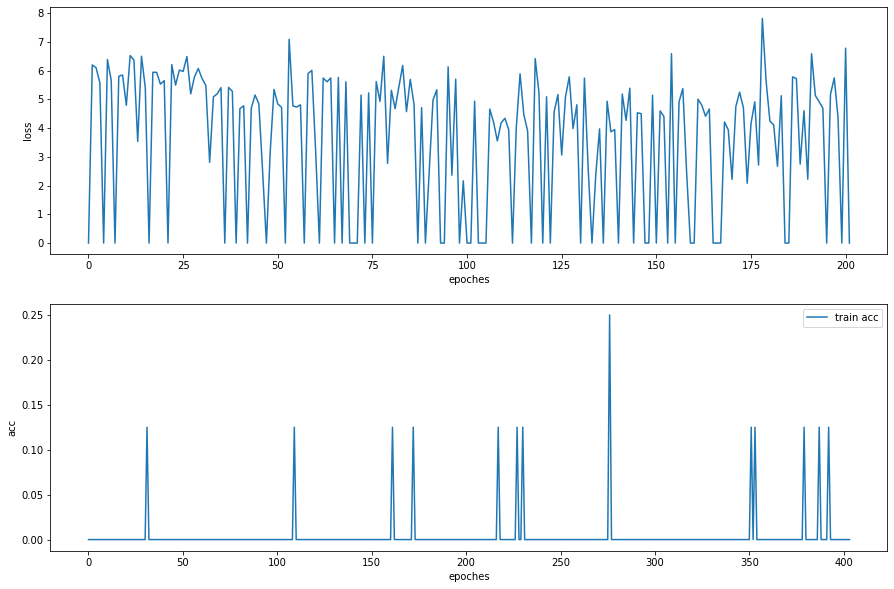

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(losses, label = 'train loss')
ax2.plot(train_accuracies, label = 'train acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [40]:

model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/db_QA.pt'))
best_train_loss = float('inf')
test_accuracies = []
test_losses = []
# run loop 3 times
for epoch in range(5):
  # first, set the mode of the model to train
  # model.train()

  # progress bar
  loop = tqdm(val_dataloader, leave=True)
  with torch.no_grad():
    # loop over each batch 
    for batch in loop:
      # zero out the optimizer
      # optimizer.zero_grad()

      # grab the batch attributes and attach them to the GPU device
      input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)

      # Feedforward!!!
      outputs = model(input_ids, attention_mask, start_positions=start_positions, end_positions=end_positions)

      # Compute the Loss
      loss = outputs[0]

      # BACKPROPAGATION!!!!
      # loss.backward()

      # update parameters for the next run
      # optimizer.step()

      test_losses.append(loss.item())
      
      # get the prediction for the start and end token for answer
      start_probs = outputs['start_logits']
      end_probs = outputs['end_logits']
      
      start_pred = torch.argmax(start_probs, dim=1)
      end_pred = torch.argmax(end_probs, dim=1)
      
      # append the accuracy
      test_accuracies.append(((start_pred == start_positions).sum() / len(start_pred)).item())
      test_accuracies.append(((end_pred == end_positions).sum() / len(end_pred)).item())
      
      avg_acc = sum(test_accuracies) / len(test_accuracies)
      print(f'[{epoch + 1}] \nloss_total: {loss.item():.2f},\nTrain_accuracy: {avg_acc*100:.2f} %')
      clear_output(wait=True) 
      # display some stuff here
      loop.set_description(f'Epoch {epoch}')
      loop.set_postfix(loss=loss.item())

Epoch 4: 100%|██████████| 51/51 [00:15<00:00,  3.35it/s, loss=2.92]


In [41]:
print(f'[{epoch + 1}] \nloss_total: {loss.item():.2f}\nTest_accuracy: {avg_acc*100:.2f} %')


[5] 
loss_total: 2.92
Test_accuracy: 0.12 %


In [42]:
import pickle

with open("train_loss", "wb") as fp:   #Pickling
  pickle.dump(test_losses, fp)

with open("train_accuracy", "wb") as fp:   #Pickling
  pickle.dump(test_accuracies, fp)

Text(0, 0.5, 'acc')

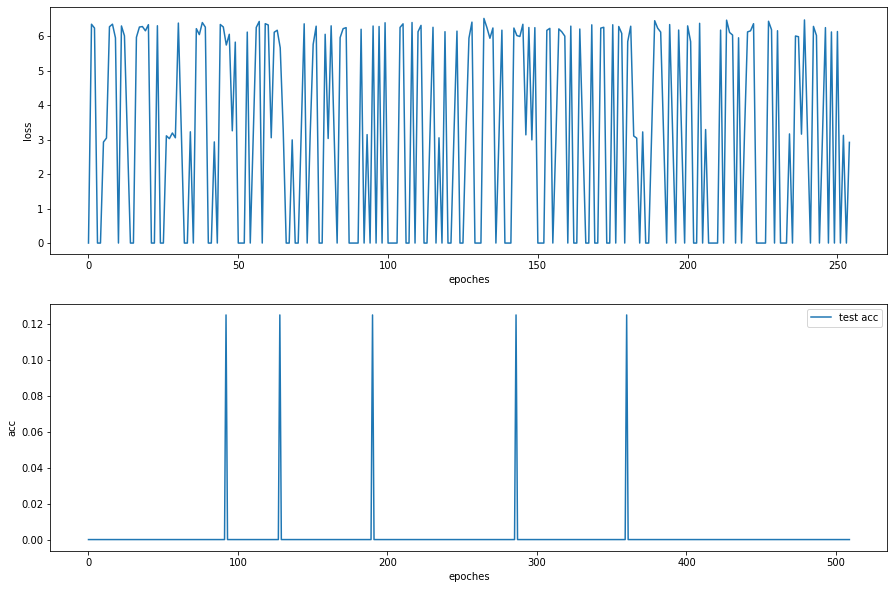

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(test_losses, label = 'test loss')
ax2.plot(test_accuracies, label = 'test acc')
plt.legend()
ax1.set_xlabel('epoches')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoches')
ax2.set_ylabel('acc')


In [46]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

question = val_questions[:2]
context = val_contexts[:2]

test_tokenized = tokenizer(question, context, truncation=True, padding=True)
print(test_tokenized.keys())
# tokens = tokenizer.convert_ids_to_tokens(test_tokenized) #input tokens
print(val_tokenized[0])
add_token_positions(test_tokenized, val_answers[:2])
print(test_tokenized.keys())
test_data = CustomDataset(test_tokenized)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

dict_keys(['input_ids', 'attention_mask'])
Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [47]:
print(test_tokenized.input_ids[0][:2])
print(len(test_tokenized.input_ids[0]))

[101, 2054]
512


In [48]:
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/db_QA.pt'))
model = model.to(device)

# run loop 3 times
# for epoch in range(1):
with torch.no_grad():
  # loop over each batch 
  i = 0
  for batch in test_dataloader:
    # grab the batch attributes and attach them to the GPU device
    input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    start_probs = outputs['start_logits']
    end_probs = outputs['end_logits']
    
    start_pred = torch.argmax(start_probs, dim=1)
    end_pred = torch.argmax(end_probs, dim=1)
    # print(start_pred, end_pred)

    # predict_answer_tokens = test_tokenized.input_ids[0][start_pred : end_pred + 1]
    # print("Predicted Answer:\n")
    # print(tokenizer.decode(predict_answer_tokens))

    predict_answer_tokens = test_tokenized.input_ids[0][start_pred : end_pred + 1]
    predicted_answer = tokenizer.decode(predict_answer_tokens)
    print("Question ",i+1,":\n",question[i],'\n')
    print("Predicted Answer ",i+1,":\n",predicted_answer,'\n')
    i += 1

Question  1 :
 What are other  effects? 

Predicted Answer  1 :
 / pmc7052386 / sha : 45a566c71056ba4faab425b4f7e9edee6320e4a4 authors : tan, kai sen ; lim, rachel liyu ; liu, jing ; ong, hsiao hui ; tan, vivian jiayi ; lim, hui fang ; chung, kian fan ; adcock, ian m. ; chow, vincent t. ; wang, de yun date : 2020 - 02 - 25 doi : 10. 3389 / fcell. 2020. 00099 license : cc - by abstract : respiratory virus infection is one of the major sources of exacerbation of chronic airway inflammatory diseases. these exacerbations are associated with high morbidity and even mortality worldwide. the current understanding on viral - induced exacerbations is that viral infection increases airway inflammation which aggravates disease symptoms. recent advances in in vitro air - liquid interface 3d cultures, organoid cultures and the use of novel human and animal challenge models have evoked new understandings as to the mechanisms of 

Question  2 :
 What is the  effect of viral components remaining in th

In [ ]:
# def train(model, train_dataloader):

#   # run loop 3 times
#   for epoch in range(1):
#     # first, set the mode of the model to train
#     model.train()

#     # progress bar
#     loop = tqdm(train_dataloader, leave=True)

#     # loop over each batch 
#     for batch in loop:
#       # zero out the optimizer
#       optim.zero_grad()

#       # grab the batch attributes and attach them to the GPU device
#       input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)

#       # Feedforward!!!
#       outputs = model(input_ids, attention_mask, start_positions=start_positions, end_positions=end_positions)

#       # Compute the Loss
#       loss = outputs[0]

#       # BACKPROPAGATION!!!!
#       loss.backward()

#       # update parameters for the next run
#       optim.step()


#       # display some stuff here
#       loop.set_description(f'Epoch {epoch}')
#       loop.set_postfix(loss=loss.item())


In [ ]:
# train(model, train_dataloader)

In [ ]:
# def evaluate(model, val_dataloader):
#     # set to evaluate mode
#     model.eval()
    
#     # keep track of accuracies
#     accuracies = []
#     best_train_loss = float('inf')

#     # loop through batches
#     for batch in val_dataloader:
#         # grab the batch attributes and attach them to the GPU device
#         input_ids, attention_mask, start_positions, end_positions = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['start_positions'].to(device), batch['end_positions'].to(device)
        
#         # make prediction
#         outputs = model(input_ids, attention_mask=attention_mask)
        
#         # get the prediction for the start and end token for answer
#         start_probs = outputs['start_logits']
#         end_probs = outputs['end_logits']
        
#         start_pred = torch.argmax(start_probs, dim=1)
#         end_pred = torch.argmax(end_probs, dim=1)
        
#         # append the accuracy
#         accuracies.append(((start_pred == start_positions).sum() / len(start_pred)).item())
#         accuracies.append(((end_pred == end_positions).sum() / len(end_pred)).item())

#     avg_acc = sum(accuracies) / len(accuracies)
#     if loss.item() < best_train_loss:
#       best_train_loss = loss.item()
#       torch.save(model.state_dict(), 'db_QA.pt')
#     return avg_acc
    

In [ ]:
# avg_acc = evaluate(model, val_dataloader)

In [ ]:
# avg_acc